# Notebook Approche Non Supervisée

In [27]:
from sklearn.ensemble import RandomForestClassifier
import mlflow
import mlflow.sklearn
import pandas as pd
import spacy
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import time


def create_confusion_matrix(conf_matrix, path):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Combined Pipeline')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(path)
    plt.show()


def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_params):
    with mlflow.start_run():
        # Paramètres du modèle
        for key, value in model_params.items():
            mlflow.log_param(key, value)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")

def train_and_evaluate(X, y):
    mlflow.start_run()
    param_max_depth = 10
    param_n_estimators = 100

    # Enregistrez les paramètres
    mlflow.log_param("max_depth", param_max_depth)
    mlflow.log_param("n_estimators", param_n_estimators)

    model = RandomForestClassifier(max_depth=param_max_depth, n_estimators=param_n_estimators)
    model.fit(X, y)
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(model, "model")
    mlflow.end_run()

def evaluate_and_log_metrics(experiment_name, model_name, model_type, y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')

    with mlflow.start_run():
        mlflow.set_experiment(experiment_name)
        mlflow.log_param("model_type", model_type)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        # Enregistrer le modèle dans le registre MLFlow
        model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
        mlflow.register_model(model_uri, model_name)
        
        # Passer le modèle en staging
        switch_model_to_staging(mlflow, model_name)
    return accuracy, precision, recall, f1

def switch_model_to_staging(mlflow, model_name):
    client = mlflow.tracking.MlflowClient()
    model_version_details = client.get_latest_versions(model_name, stages=["None"])[0]
    
    client.transition_model_version_stage(
        name=model_name,
        version=model_version_details.version,
        stage="Staging"
    )

import matplotlib.pyplot as plt

def plot_monthly_metrics(accuracies, precisions, recalls, f1_scores, months, file_path):
    plt.figure(figsize=(12, 6))
    plt.plot(months, accuracies, label='Accuracy', marker='o')
    plt.plot(months, precisions, label='Precision', marker='s')
    plt.plot(months, recalls, label='Recall', marker='^')
    plt.plot(months, f1_scores, label='F1 Score', marker='d')

    plt.xlabel('Months')
    plt.ylabel('Metrics')
    plt.title('Monthly Performance Metrics')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()
    plt.close()


In [28]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("dataset_cleaned.csv")

# Assurez-vous que 'creationdate' est une date
data['creationdate'] = pd.to_datetime(data['creationdate'])

train_data, test_data = train_test_split(data, test_size=0.3)

print(len(test_data))
print(len(train_data))

# Filtrage des données de test
train_data_filtered = train_data[train_data['creationdate'] < pd.Timestamp('2023-01-01')]

# Filtrage des données de test
test_data_filtered = test_data[test_data['creationdate'] < pd.Timestamp('2023-01-01')]

X_train = train_data_filtered[['title_lemmatized', 'body_lemmatized', 'creationdate']]
y_train_original = train_data_filtered['tags_transformed']

X_test = test_data_filtered[['title_lemmatized', 'body_lemmatized', 'creationdate']]
y_test_original = test_data_filtered['tags_transformed']

13609
31753


## MultiLabelBinarizer (Pour Entrainer le modèle sur les 100 tags les plus fréquents)

In [29]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from collections import Counter

y_train_lists = [tags_str.split(',') for tags_str in y_train_original]
y_test_lists = [tags_str.split(',') for tags_str in y_test_original]
tag_counts = Counter(tag for tags_list in y_train_lists for tag in tags_list)

# Garder les 100 tags les plus fréquents
N = 100
top_tags = [tag for tag, _ in tag_counts.most_common(N)]

# Convertir les listes de tags en représentation binaire
mlb = MultiLabelBinarizer(classes=top_tags)
y_train = mlb.fit_transform(y_train_lists)
y_test = mlb.transform(y_test_lists)

print(y_train.shape)
print(y_test.shape)

(31715, 100)
(13595, 100)


/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.app', '.class-file', '.doc', '.htaccess', '.lib', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-4.5', '.net-4.7.2', '.net-4.8', '.net-5', '.net-6.0', '.net-7.0', '.net-assembly', '.net-attributes', '.net-core', '.net-core-2.0', '.net-core-2.1', '.net-core-2.2', '.net-core-3.0', '.net-core-3.1', '.net-core-logging', '.net-core-rc1', '.net-core-rc2', '.net-framework-version', '.net-mac', '.net-standard', '.net-standard-1.5', '.net-standard-2.0', '.net-standard-2.1', '.profile', '.when', '128-bit', '16-bit', '2-way-object-databinding', '2d', '3-tier', '32-bit', '32bit-64bit', '3d', '3d-model', '3d-reconstruction', '3des', '3dtouch', '3g', '4g', '64-bit', '7zip', 'a-star', 'a2dp', 'aac', 'aadhaar', 'aapt', 'aar', 'abaddressbook', 'abbr', 'abbreviation', 'abc', 'abcl', 'abi', 'abort', 'abrecord', 'absl-py', 'absolute', 'absolute-path', 'absolute-value'

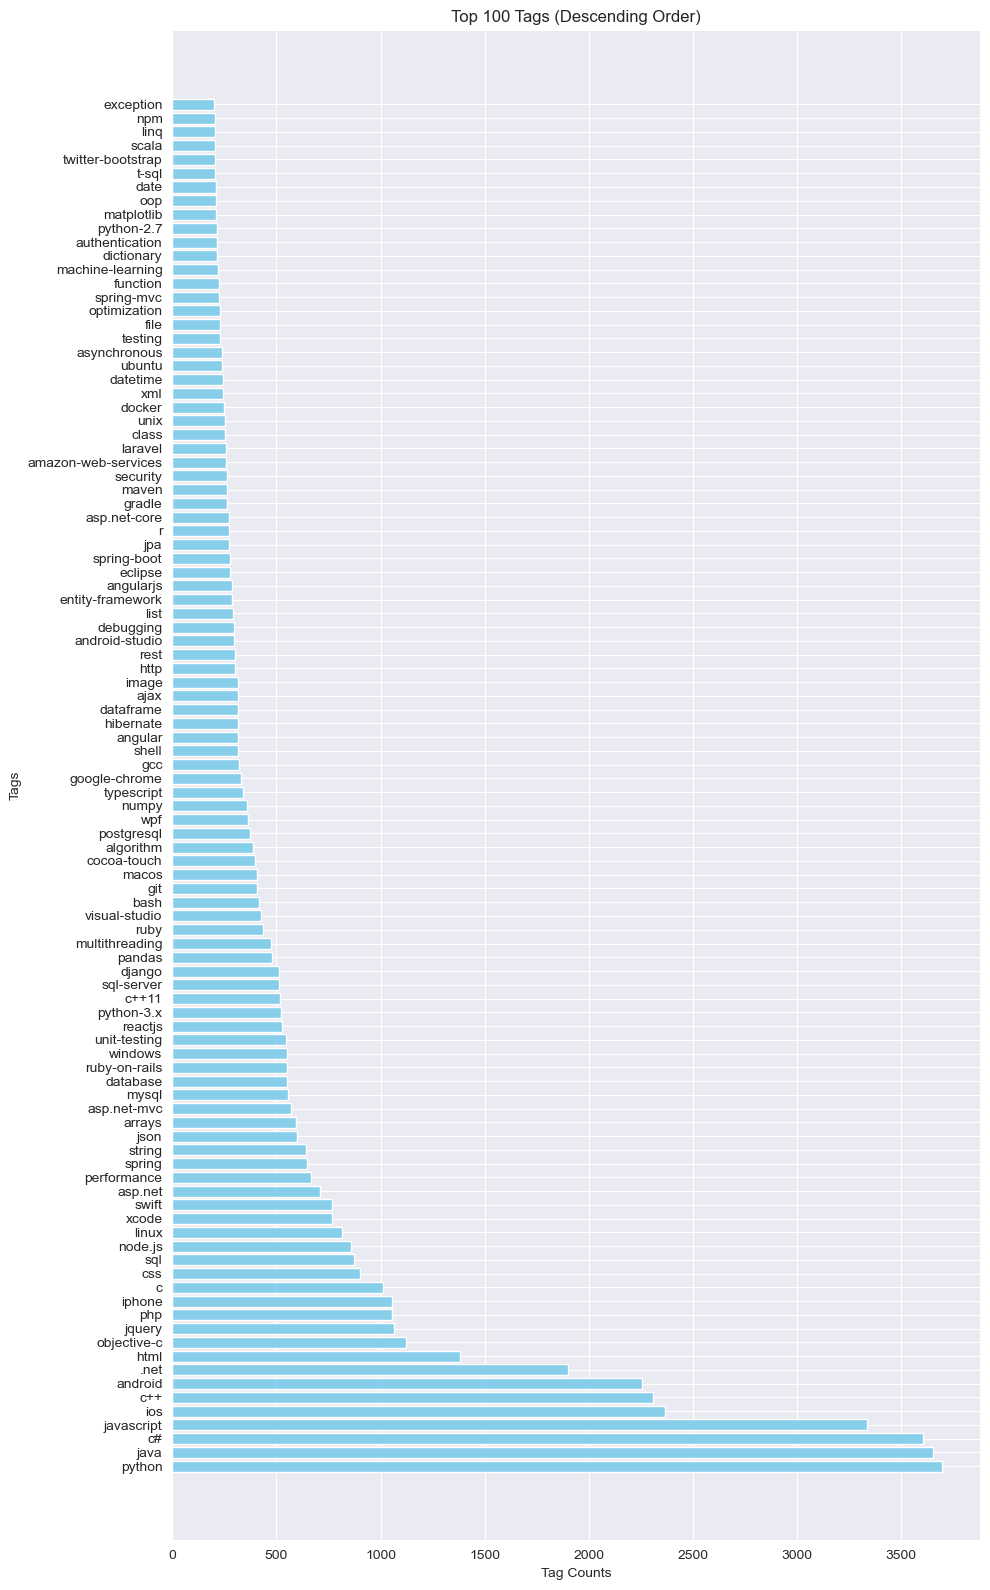

In [30]:
import matplotlib.pyplot as plt
from collections import Counter

top_tag_counts = Counter(tag for tags_list in y_train_lists for tag in tags_list if tag in top_tags)
top_tag_names, top_tag_counts = zip(*top_tag_counts.items())

sorted_indices = sorted(range(len(top_tag_counts)), key=lambda k: top_tag_counts[k], reverse=True)
top_tag_names = [top_tag_names[i] for i in sorted_indices]
top_tag_counts = [top_tag_counts[i] for i in sorted_indices]

plt.figure(figsize=(10, 16))
plt.barh(top_tag_names, top_tag_counts, color='skyblue')
plt.xlabel('Tag Counts')
plt.ylabel('Tags')
plt.title('Top {} Tags (Descending Order)'.format(N))
plt.tight_layout()

plt.show()


## CountVectorizer

### Train OneVsRestClassifier

In [31]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

title_classifier = MultinomialNB()
body_classifier = MultinomialNB()
combined_classifier = MultinomialNB()

titleOneRestclassifier = OneVsRestClassifier(title_classifier)
bodyOneRestclassifier = OneVsRestClassifier(body_classifier)
combinedOneRestclassifier = OneVsRestClassifier(combined_classifier)

title_pipeline = Pipeline([
    ('vectorizer_title', CountVectorizer()),
    ('classifier', titleOneRestclassifier)
])

body_pipeline = Pipeline([
    ('vectorizer_body', CountVectorizer()),
    ('classifier', bodyOneRestclassifier)
])

combined_pipeline = Pipeline([
    ('vectorizer_combined', CountVectorizer()),
    ('classifier', combinedOneRestclassifier)
])

X_train_combined = X_train['title_lemmatized'] + ' ' + X_train['body_lemmatized']
X_test_combined = X_test['title_lemmatized'] + ' ' + X_test['body_lemmatized']

title_pipeline.fit(X_train['title_lemmatized'], y_train)
body_pipeline.fit(X_train['body_lemmatized'], y_train)
combined_pipeline.fit(X_train_combined, y_train)

Pipeline(steps=[('vectorizer_combined', CountVectorizer()),
                ('classifier', OneVsRestClassifier(estimator=MultinomialNB()))])

### Predict OneVsRestClassifier

In [32]:
import numpy as np

X_title_test_transformed = title_pipeline.named_steps['vectorizer_title'].transform(X_test['title_lemmatized'])
X_body_test_transformed = body_pipeline.named_steps['vectorizer_body'].transform(X_test['body_lemmatized'])
X_combined_test_transformed = combined_pipeline.named_steps['vectorizer_combined'].transform(X_test_combined)

predictions_proba_title = title_pipeline.predict_proba(X_test['title_lemmatized'])
predictions_proba_body = body_pipeline.predict_proba(X_test['body_lemmatized'])
predictions_proba_combined = combined_pipeline.predict_proba(X_test_combined)

n_top_classes = 5

top_classes_indices_title = np.argsort(predictions_proba_title)[:, -n_top_classes:]
top_classes_indices_body = np.argsort(predictions_proba_body)[:, -n_top_classes:]
top_classes_indices_combined = np.argsort(predictions_proba_combined)[:, -n_top_classes:]

top_tags_title = mlb.classes_[top_classes_indices_title]
top_tags_body = mlb.classes_[top_classes_indices_body]
top_tags_combined = mlb.classes_[top_classes_indices_combined]


## Sauvegarde du modèle

In [33]:
from joblib import dump

dump(combined_pipeline, 'model_supervised_OneVsRestClassifier_MultinomialNB.joblib')

dump(mlb, 'model_supervised_MultinomialNB.joblib')

['model_supervised_MultinomialNB.joblib']

## Récupérer les tags les plus proches (en utilisant predict_proba)

In [40]:
# Liste des questions à prédire (title + body)
questions_to_predict = ["How can you implement a thread-safe singleton in Java?", "#*Whatnot** is a livestream shopping platform and marketplace backed by Andreessen Horowitz, Y Combinator, and CapitalG. We’re building the future of ecommerce, bringing together community, shopping and entertainment. We are committed to our values, whether working remotely or from one of our offices. We are building a team that has experience from top tech, retail and payments platforms in the world. We’re innovating in the fast-paced world of live auctions in categories including sports, fashion, video games, and streetwear. The platform couples rigorous seller vetting with a focus on community to create a welcoming space for buyers and sellers to share their passions with others. And, we’re growing. Whatnot has been the fastest growing marketplace in the US over the past two years and we’re hiring forward-thinking problem solvers across all functional areas. Retail disruption is one of the largest opportunities in the startup space today. Livestream shopping is taking off around the world – a $300B GMV market in China that’s grown 100% YoY. Whatnot is bringing it to the world through a community-first approach, starting in the U.S. where retail is a $5T market opportunity! We are looking for intellectually curious, highly motivated individuals to join us for a 12-week remote internship during summer 2024. Our interns work in cross-functional multidisciplinary teams enabling you to directly impact the direction of our platform. Your code and ideas will contribute to solving some of the most complex technical challenges we face today and define future engineering initiatives.    - Building new features for users in our live-streams - Implementing growth tactics and strategies to scale our buyer and seller flows - Building systems at scale that help us deliver a high trust marketplace experience By the end of your internship, you will have contributed to one of the fastest growing marketplaces ever while gaining core industry skills of project ideation, management and collaboration Curious about who thrives at Whatnot? We’ve found that low ego, a growth mindset, and leaning into action and high impact goes a long way here. As our next Engineering Intern you should have some industry software engineering experience, plus: - Pursuing a degree in computer science or other related major graduating in 2025 - Problem solver and out-of-the-box thinker - Willing to take risks and build product and systems for 1M+ users    - Ability to pick up on new technologies quickly"]

predictions_proba_combined_multiple = combined_pipeline.predict_proba(questions_to_predict)
n_top_classes = 5

# itérer sur chaque prédiction
for i, question in enumerate(questions_to_predict):
    top_classes_indices = predictions_proba_combined_multiple.argsort(axis=1)[:, -n_top_classes:][i]
    top_classes_probabilities = predictions_proba_combined_multiple[i, top_classes_indices]

    # Tri des classes et des probabilités par ordre décroissant de probabilité
    sorted_indices = np.argsort(top_classes_probabilities)[::-1]
    top_tags_combined_sorted = mlb.classes_[top_classes_indices[sorted_indices]]
    top_classes_probabilities_sorted = top_classes_probabilities[sorted_indices]

    print(f"Tags associés pour la question '{question}':", list(zip(top_tags_combined_sorted, top_classes_probabilities_sorted)))
    print("\n")


Tags associés pour la question 'How can you implement a thread-safe singleton in Java?': [('java', 0.8288512858579073), ('c#', 0.039509829940184954), ('multithreading', 0.03729987605979391), ('c++', 0.020121424554083008), ('.net', 0.004928877410812941)]


Tags associés pour la question '#*Whatnot** is a livestream shopping platform and marketplace backed by Andreessen Horowitz, Y Combinator, and CapitalG. We’re building the future of ecommerce, bringing together community, shopping and entertainment. We are committed to our values, whether working remotely or from one of our offices. We are building a team that has experience from top tech, retail and payments platforms in the world. We’re innovating in the fast-paced world of live auctions in categories including sports, fashion, video games, and streetwear. The platform couples rigorous seller vetting with a focus on community to create a welcoming space for buyers and sellers to share their passions with others. And, we’re growing. 

## Évaluation du modèle de référence

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

top_tags_title_predicted = mlb.transform(top_tags_title)
top_tags_body_predicted = mlb.transform(top_tags_body)
top_tags_combined_predicted = mlb.transform(top_tags_combined)
experiment_name = 'supervised OneVsRestClassifier MultinomialNB'
model_name = 'supervised OneVsRestClassifier MultinomialNB'

# Evaluation and logging for the title pipeline
accuracy_title, precision_title, recall_title, f1_title = evaluate_and_log_metrics(experiment_name, model_name, "title", y_test, top_tags_title_predicted)
print("\nTitle Pipeline Metrics (Top 5 classes):")
print("Accuracy:", accuracy_title)
print("Precision:", precision_title)
print("Recall:", recall_title)
print("F1 Score:", f1_title)

# Evaluation and logging for the body pipeline
accuracy_body, precision_body, recall_body, f1_body = evaluate_and_log_metrics(experiment_name, model_name, "body", y_test, top_tags_body_predicted)
print("\nBody Pipeline Metrics (Top 5 classes):")
print("Accuracy:", accuracy_body)
print("Precision:", precision_body)
print("Recall:", recall_body)
print("F1 Score:", f1_body)

# Evaluation and logging for the combined pipeline
accuracy_combined, precision_combined, recall_combined, f1_combined = evaluate_and_log_metrics(experiment_name, model_name, "combined", y_test, top_tags_combined_predicted)
print("\nCombined Pipeline Metrics (Top 5 classes):")
print("Accuracy:", accuracy_combined)
print("Precision:", precision_combined)
print("Recall:", recall_combined)
print("F1 Score:", f1_combined)


Registered model 'supervised OneVsRestClassifier MultinomialNB' already exists. Creating a new version of this model...
Created version '31' of model 'supervised OneVsRestClassifier MultinomialNB'.
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_73504/1558856246.py:79: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.1/model-registry.html#migrating-from-stages
  model_version_details = client.get_latest_versions(model_name, stages=["None"])[0]
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_73504/1558856246.py:81: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of mod


Title Pipeline Metrics (Top 5 classes):
Accuracy: 0.001471129091577786
Precision: 0.3641936145920821
Recall: 0.6965401785714286
F1 Score: 0.4212188802945961


Registered model 'supervised OneVsRestClassifier MultinomialNB' already exists. Creating a new version of this model...
Created version '32' of model 'supervised OneVsRestClassifier MultinomialNB'.
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_73504/1558856246.py:79: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.1/model-registry.html#migrating-from-stages
  model_version_details = client.get_latest_versions(model_name, stages=["None"])[0]
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_73504/1558856246.py:81: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of mod


Body Pipeline Metrics (Top 5 classes):
Accuracy: 0.0003677822728944465
Precision: 0.36893604003040603
Recall: 0.5423735119047619
F1 Score: 0.3063299295254074

Combined Pipeline Metrics (Top 5 classes):
Accuracy: 0.0004413387274733358
Precision: 0.3914755721541184
Recall: 0.5848214285714286
F1 Score: 0.3390372687060564


Registered model 'supervised OneVsRestClassifier MultinomialNB' already exists. Creating a new version of this model...
Created version '33' of model 'supervised OneVsRestClassifier MultinomialNB'.
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_73504/1558856246.py:79: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.1/model-registry.html#migrating-from-stages
  model_version_details = client.get_latest_versions(model_name, stages=["None"])[0]
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_73504/1558856246.py:81: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of mod

## Évaluations du modèle par mois

- Période de références, toutes les données avant jusqu'à fin décembre 2022.
- On entraine le modèle une seule fois sur la période de référence.
- On compare les résultats du modèle par mois (chaque mois de 2023) par rapport aux résultats de référence.

### Creation de monthly_test_data avec les données de chaque mois

In [36]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("dataset_cleaned.csv")

# Assurez-vous que 'creationdate' est une date
data['creationdate'] = pd.to_datetime(data['creationdate'])

# Filtrage des données de test
test_data_only_2023 = data[data['creationdate'] >= pd.Timestamp('2023-01-01')]

test_data_only_2023.to_csv("dataset_over_months_2023.csv", index=False)


In [37]:
print(len(test_data_only_2023))
monthly_test_data = {}
for month in range(1, 13):
    monthly_data = test_data_only_2023[test_data_only_2023['creationdate'].dt.year == 2023]
    monthly_data = monthly_data[monthly_data['creationdate'].dt.month == month]

    if not monthly_data.empty:
        monthly_test_data[month] = monthly_data

for month, data in monthly_test_data.items():
    print(f"Nombre de lignes pour le mois {month}: {len(data)}")


52
Nombre de lignes pour le mois 1: 7
Nombre de lignes pour le mois 2: 8
Nombre de lignes pour le mois 3: 6
Nombre de lignes pour le mois 4: 2
Nombre de lignes pour le mois 5: 4
Nombre de lignes pour le mois 6: 9
Nombre de lignes pour le mois 7: 3
Nombre de lignes pour le mois 8: 6
Nombre de lignes pour le mois 9: 4
Nombre de lignes pour le mois 10: 1
Nombre de lignes pour le mois 11: 1
Nombre de lignes pour le mois 12: 1


### Prédiction sur chaque mois

In [38]:
import numpy as np
import calendar

n_top_classes = 5
accuracy_combined = []
precision_combined = []
recall_combined = []
f1_combined = []
months = []

for month, X_test_month in monthly_test_data.items():
    month_name = calendar.month_name[month]
    months.append(month_name)
    experiment_name = f"{month_name} 2023 - supervised OneVsRestClassifier MultinomialNB"
    model_name = "supervised OneVsRestClassifier MultinomialNB"

    # Préparation des données combinées pour le mois
    X_test_combined_month = X_test_month['title_lemmatized'] + ' ' + X_test_month['body_lemmatized']
    y_test_lists = [tags_str.split(',') for tags_str in X_test_month['tags_transformed']]
    y_test_month = mlb.transform(y_test_lists)
    
    # Prédiction avec le modèle de référence (en utilisant predict_proba)
    predictions_proba_combined = combined_pipeline.predict_proba(X_test_combined_month)
    top_classes_indices_combined = np.argsort(predictions_proba_combined)[:, -n_top_classes:]
    top_tags_combined = mlb.classes_[top_classes_indices_combined]
    top_tags_combined_predicted = mlb.transform(top_tags_combined)

    # Évaluation des performances pour le mois
    accuracy_combined_month, precision_combined_month, recall_combined_month, f1_combined_month = evaluate_and_log_metrics(
        experiment_name, model_name, f"combined_{month}", y_test_month, top_tags_combined_predicted)

    accuracy_combined.append(accuracy_combined_month)
    precision_combined.append(precision_combined_month)
    recall_combined.append(recall_combined_month)
    f1_combined.append(f1_combined_month)

    # Affichage des métriques pour le mois
    print(f"\nCombined Pipeline Metrics for {month_name}:")
    print("Accuracy:", accuracy_combined_month)
    print("Precision:", precision_combined_month)
    print("Recall:", recall_combined_month)
    print("F1 Score:", f1_combined_month)


/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['android-gradle-plugin', 'apt', 'browser-extension', 'build.gradle', 'clang', 'compiler-optimization', 'cross-browser', 'dockerfile', 'firefox', 'kotlin', 'kubernetes', 'loop-unrolling', 'menu', 'mongodb', 'new-operator', 'next.js', 'service-worker', 'settings', 'template-meta-programming', 'ubuntu-22.04'] will be ignored
  warnings.warn(
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control 


Combined Pipeline Metrics for January:
Accuracy: 0.0
Precision: 0.3766666666666667
Recall: 0.5333333333333333
F1 Score: 0.40444444444444444

Combined Pipeline Metrics for February:
Accuracy: 0.0
Precision: 0.48214285714285715
Recall: 0.7142857142857143
F1 Score: 0.5404761904761904


/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['android-gradle-plugin', 'auth-guard', 'avif', 'browser', 'canactivate', 'canactivatechild', 'candeactivate', 'cpython', 'cython', 'fpm', 'kotlin', 'microsoft-edge', 'next.js', 'numba', 'path', 'pypi', 'pyproject.toml', 'python-internals', 'python-packaging', 'python-poetry', 'react-server-components', 'router', 'setuptools', 'simd', 'sqlsrv', 'w3c'] will be ignored
  warnings.warn(
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true sampl


Combined Pipeline Metrics for March:
Accuracy: 0.0
Precision: 0.7416666666666667
Recall: 1.0
F1 Score: 0.7888888888888889

Combined Pipeline Metrics for April:
Accuracy: 0.0
Precision: 0.875
Recall: 1.0
F1 Score: 0.9166666666666666


/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Registered model 'supervised OneVsRestClassifier Multinom


Combined Pipeline Metrics for May:
Accuracy: 0.0
Precision: 0.3055555555555555
Recall: 0.5
F1 Score: 0.37777777777777777

Combined Pipeline Metrics for June:
Accuracy: 0.0
Precision: 0.45588235294117646
Recall: 0.8235294117647058
F1 Score: 0.5372549019607843


/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Registered model 'supervised OneVsRestClassifier Multinom


Combined Pipeline Metrics for July:
Accuracy: 0.0
Precision: 0.5333333333333333
Recall: 0.8
F1 Score: 0.62

Combined Pipeline Metrics for August:
Accuracy: 0.0
Precision: 0.46969696969696967
Recall: 0.7272727272727273
F1 Score: 0.5238095238095238


/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['compiler-errors', 'compiler-optimization', 'expo', 'glibc', 'integer-overflow', 'ios-simulator', 'java-21', 'lombok', 'react-native', 'restrict-qualifier', 'undefined-behavior', 'upgrade', 'variable-length-array'] will be ignored
  warnings.warn(
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/anaconda3/li


Combined Pipeline Metrics for September:
Accuracy: 0.0
Precision: 0.5714285714285714
Recall: 0.5714285714285714
F1 Score: 0.5714285714285714

Combined Pipeline Metrics for October:
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
F1 Score: 0.5


/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
Registered model 'supervised OneVsRestClassifier Multinom


Combined Pipeline Metrics for November:
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
F1 Score: 0.5

Combined Pipeline Metrics for December:
Accuracy: 0.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['assignment-operator', 'double', 'integer', 'multiplication'] will be ignored
  warnings.warn(
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no

## Graph de l'évolution du score à travers les mois

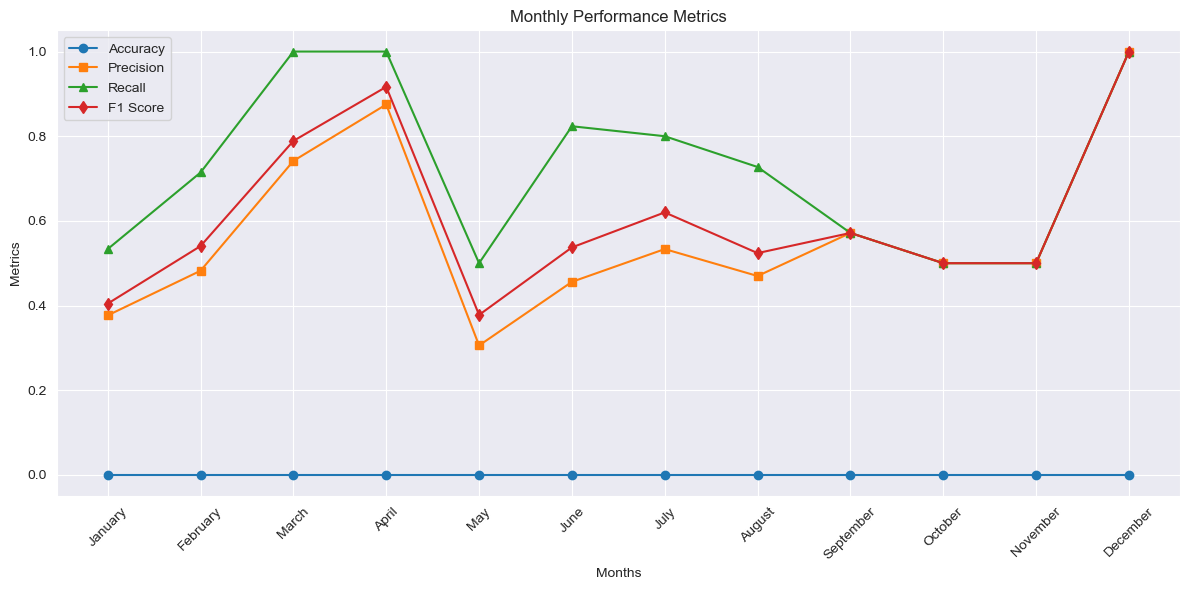

In [39]:
plot_monthly_metrics(accuracy_combined, precision_combined, recall_combined, f1_combined, months, 'scoring_over_time.png')

## Tests unitaires

import numpy as np
import unittest
from unittest.mock import patch, MagicMock
import mlflow
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming your functions are defined as above

class TestMLflowFunctions(unittest.TestCase):
    @patch('__main__.switch_model_to_staging')
    @patch('mlflow.register_model')
    @patch('mlflow.start_run')
    @patch('mlflow.active_run')
    def test_evaluate_and_log_metrics(self, mock_active_run, mock_start_run, mock_register_model, mock_switch_model_to_staging):
        y_test = np.random.randint(0, 2, 20)
        y_predicted = np.random.randint(0, 2, 20)
    
        # Setting up the mock for mlflow.start_run
        mock_run = MagicMock()
        mock_run.info.run_id = "mock_run_id"
        mock_start_run.return_value.__enter__.return_value = mock_run
        mock_active_run.return_value = mock_run
    
        accuracy, precision, recall, f1 = evaluate_and_log_metrics("experiment_name", "model_name", "model_type", y_test, y_predicted)
    
        # Assertions
        mock_start_run.assert_called_once()
        mock_register_model.assert_called_with(f"runs:/mock_run_id/model", "model_name")
        self.assertEqual(accuracy, accuracy_score(y_test, y_predicted))
        self.assertEqual(precision, precision_score(y_test, y_predicted, average='weighted'))
        self.assertEqual(recall, recall_score(y_test, y_predicted, average='weighted'))
        self.assertEqual(f1, f1_score(y_test, y_predicted, average='weighted'))


    @patch('mlflow.tracking.MlflowClient')
    def test_switch_model_to_staging(self, mock_mlflow_client):
        # Mock the MLflowClient and its method
        mock_client = MagicMock()
        mock_mlflow_client.return_value = mock_client
    
        # Create a mock model version object
        mock_model_version = MagicMock()
        mock_model_version.version = '1'
    
        # Configure get_latest_versions to return a list with the mock model version
        mock_client.get_latest_versions.return_value = [mock_model_version]
    
        # Call the function
        switch_model_to_staging(mlflow, "model_name")
    
        # Assertions
        mock_mlflow_client.assert_called_once()
        mock_client.get_latest_versions.assert_called_with("model_name", stages=["None"])
        mock_client.transition_model_version_stage.assert_called_once_with(name="model_name", version='1', stage="Staging")


unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestMLflowFunctions))
